# Import Object

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from models import AttentionRNN
from train_model import train_timeseries_net

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [28]:
train_x = pd.read_csv("./data/2_X_train_succint.csv").values
train_y = pd.read_csv("./data/2_Y_train.csv").values.reshape(-1)

ss = preprocessing.StandardScaler()
train_x[:, :9] = ss.fit_transform(train_x[:, :9])

num_days = int(train_x.shape[0] / 16)
train_x = train_x.reshape(num_days, 16, 14)
train_y = train_y.reshape(num_days, 16, 1)
train_x, test_x, train_y, test_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size=0.2,
                                                    shuffle=True)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)

# Set Free Parameters

In [29]:
input_size = 14
num_layers = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.0005
num_epochs = 50
dropout_ratio = 0.5

# Instantiate Model, Criterion, Optimizer

In [30]:
model = AttentionRNN(input_size, hidden_size,
                     num_layers, num_classes, dropout_ratio).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=1e-3, eps=1e-11)

# Training

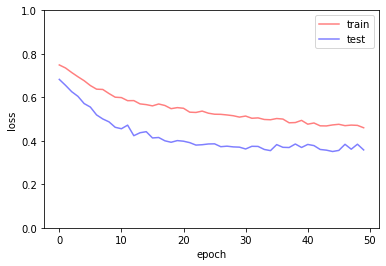

In [31]:
model = train_timeseries_net(model, criterion, optimizer,
                             num_epochs, train_loader, test_x,
                             test_y, device)

# Accuracy

In [32]:
model.eval()
score_y = model(test_x, device).reshape(-1)
score_y = torch.sigmoid(score_y)
pred_y = torch.tensor([1 if i>0.5 else 0 for i in score_y]).to(device)
test_y = test_y.reshape(-1)

print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(0.9187, device='cuda:0')


In [33]:
test_y = test_y.to('cpu').detach().numpy().copy()
pred_y = pred_y.to('cpu').detach().numpy().copy()

print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88       104
         1.0       0.97      0.91      0.94       216

    accuracy                           0.92       320
   macro avg       0.90      0.92      0.91       320
weighted avg       0.92      0.92      0.92       320

